# r/progresspics: get posts

This notebook walks through extracting posts from the `r/progresspics` subreddit.

1. The top 20,000 (in terms of subscribers) subreddits have been archived here: https://academictorrents.com/details/c398a571976c78d346c325bd75c47b82edf6124e
  * The archive contains subfolders for each subreddit included
  * The file is downloaded using a torrent client
  * Link was posted to academictorrents.com by user `Watchful1`
  * The torrent file has subfolders for each subreddit and within them a folder for comments and submissions, that have been scraped using `PSAW`
  * `PSAW` is dead but it's documentation shows the data elements available for submissions and comments
  * One can also choose `comments` or `submissions`
  * When torrenting, instead of downloading the multi-Terabyte archive, you can select which folders you want (in this case I chose `progresspics/submissions`)

2. The result is a zst, and code to extract the data elements to a csv is found here:  https://github.com/Watchful1/PushshiftDumps

In [2]:
# install and/or import packages/modules
import zstandard # needed to convert torrent to csv
import os
import pandas as pd
import re

In [3]:
os.chdir("/Users/iandouglas/Projects/Repos/generative-ai/")

#### Use zst_to_csv (from https://github.com/Watchful1/PushshiftDumps)

Supply arguments:

1. path to the torrented .zst file
2. output path of desired .csv
3. the columns desired
  * The available columns are those that `PSAW` created

In [9]:
# Extract r/progresspics data
# !python3 scripts/zst_to_csv.py \
#   path/to/archived/reddit/subreddits/progresspics_submissions.zst \ # torrented file
#   data/zst_extracts/progresspics_submissions.csv \ # output csv
#   id,author,selftext,title,url,thumbnail,created_utc,is_self,media,over_18,domain

### Process the data

The goal is to extract a link to the before and after image for each post.

The link(s) may be embedded in the post's text (`selftext`), or in some cases are contained directly in the `url` column.

Valid links will point to `i.imgur.com` or `i.reddituploads` or `i.redd.it`, but valid images may also be contained in galleries on imgur or reddit, or in posts at domains like `m.reddit`, or `imgur.com`, et al.

If the links are within the selftext, we will use `re` (regex) operations to isolate and extract them.

In [4]:
p = pd.read_csv("data/zst_extracts/progresspics_submissions.csv", index_col = None)
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222645 entries, 0 to 222644
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           222645 non-null  object
 1   author       222645 non-null  object
 2   selftext     97371 non-null   object
 3   title        222645 non-null  object
 4   url          218041 non-null  object
 5   thumbnail    222645 non-null  object
 6   created_utc  222645 non-null  int64 
 7   is_self      222645 non-null  bool  
 8   media        222645 non-null  object
 9   over_18      222645 non-null  bool  
 10  domain       218041 non-null  object
dtypes: bool(2), int64(1), object(8)
memory usage: 15.7+ MB


#### Let's look at top domains

In [15]:
p.domain.value_counts().head(20)

i.redd.it                     142614
imgur.com                      34280
i.imgur.com                    15414
self.progresspics              14906
i.reddituploads.com             2228
None                            1237
youtube.com                      902
m.imgur.com                      783
v.redd.it                        744
youtu.be                         725
reddit.com                       494
instagram.com                    294
digistore24.com                   75
ibb.co                            52
facebook.com                      52
vm.tiktok.com                     48
sites.google.com                  47
eshopping2021.blogspot.com        39
crackfullreal.com                 38
twitter.com                       37
Name: domain, dtype: int64

This subreddit is very large with many posts in the archive, so we can simply use domains:

    * i.redd.it: image files hosted by reddit.com
    * imgur.com: imgur posts, usually containing galleries of multiple images
    * i.imgur.com: image files hosted by imgur.com
    * i.reddituploads: image files hosted by reddit.com
    * m.imgur.com: can contains posts or images on imgur.com, but URL indicates a mobile upload

This enahnces the reproducibility of the pipeline, and limits the need to hard code request protocols for unique but uncommon domains.

Note, we retain `self.progresspics` below because this tells us the path to the images (if there are any) will be embedded in the text of the post (`selftext` column), and can be parsed.

In [5]:
# Make a list of valid domains
p_valid_domain = ['imgur.com', 'i.imgur.com', 'm.imgur.com',
                  'i.redd.it', 'i.reddituploads.com', 'self.progresspics']
# Note reddit.com is not valid because it points to posts
print(p.shape)
p = p[p.domain.isin(p_valid_domain)]
print(p.shape)

(222645, 11)
(210225, 11)


Undertake parsing `selftext` later, and process the urls to automate the ETL pipeline

### Determine download method

* if `selftext_urls` is null, we are using `url` to get the images.
  * If the `url` is a gallery, the method will be `gallery`
  * Else it's just `url` as is
* If selftext_urls is not null
  * If before and after are not null, method is `before_after`
  * Else use `selftext_url` (not, need to extract url from list)

Note, we're ignoring selftext until they are parsed later.

In [6]:
def detect_gallery(str_):
  try:
    out = re.search('imgur.com\/a\/|imgur.com\/gallery|reddit.com\/gallery', str_)
  except:
    out = False
  finally:
    return out if out else False # needed b/c if out == None then we want False, not None

def get_download_method(row):
    # Note, before/after are created after parsing selftext
    #if row['before'] and row['after']:
        #return 'before_after'
    # elif row['selftext_urls']:
        # return 'selftext_urls'
        #else:
    return 'gallery' if detect_gallery(row['url']) else 'url'

Make a column to indicate the download method for each post.

In [7]:
domains_notself = ['imgur.com', 'i.imgur.com', 'm.imgur.com',
                   'i.redd.it', 'i.reddituploads.com']
p_notself = p.query("domain.isin(@domains_notself)").copy()

p_notself['download_method'] = p_notself.apply(get_download_method, axis = 1)

p_notself.download_method.value_counts()

url        177166
gallery     18153
Name: download_method, dtype: int64

#### Clean the URLS.

If the URL points to an imgur post, but not a gallery, then appending .jpg will create a request to the image in that post. This allows to create a column containing the url to send in the request.

1. If downloading url or selftext_urls, but the url does not end with jpg, jpeg, or png, append jpg
2. Else it's a gallery, and the url is used as is.

Note, this only applies to url (not gallery) since there are no selftext_urls

In [8]:
def clean_url(row):
  if row['download_method'] == 'url':
    url = row['url']
    if not url.lower().endswith(('jpg', 'jpeg', 'png')):
        return url + '.jpg'
    else:
        return url
  elif row['download_method'] == 'selftext_urls':
    url = row['selftext_urls'][0]
    if not url.lower().endswith(('jpg', 'jpeg', 'png')):
        return url + '.jpg'
    else:
        return url
  elif row['download_method'] == 'gallery':
    return row['url']
  else:
    return None

p_notself['clean_url'] = p_notself.apply(clean_url, axis = 1)


Save

In [9]:
p_notself.to_csv("data/flat/p_notself_clean.csv", index = False)

### Parsing `selftext`

If `domain` is "self.progresspics" or `thumbnail` is "self", the image URLs are embedded in the self text in non-standard fashion. Sometimes they are wrapped in `[]` or `()` as if they are embedded hyperlinks, other times just plain text. Thankfully, all the links are already prepended by `http`. To make extracting the URLs easier, then extract what's left from there.

Another caveat is that multiple URLs might be contained in `selftext`, so we'll return a list of them (which is the typical output from `re.findall`).

While we're at it, if we find that `domain` == 'self.progresspics' or the `thumbnail` == 'self' but the selftext is `NaN`, drop this row.

In [ ]:
def add_whitespace_selftext(row):
  if (row['domain'] == 'self.progresspics') or (row['thumbnail'] == 'self'):
    return re.sub('\[|\]|\(|\)|\\n|\\t', ' ', row['selftext'])
  else:
    return row['selftext']


# First filter where the link should be in selftext, but it's NaN
print(p.shape)
p = p.query("~(((domain == 'self.progresspics') or (thumbnail == 'self')) and (selftext.isna()==True))")
print(p.shape)

# Now clean remaining selftext
p['selftext'] = p.apply(add_whitespace_selftext, axis = 1)

(210225, 11)
(209952, 11)


In [ ]:
# Now extract urls from selftext, and join them up using a custom delimiter
# Again, only if the domain or thumbnail indicates the URL is there
def get_urls(str_):
  return re.findall(r'(https?://\S+)', str_)

def apply_urls(row):
  if (row['domain'] == 'self.progresspics') or (row['thumbnail'] == 'self'):
    return get_urls(row['selftext'])
  else:
    return None

p['selftext_urls'] = p.apply(apply_urls, axis = 1)
p.selftext_urls.apply(type).value_counts()

<class 'NoneType'>    195319
<class 'list'>         14633
Name: selftext_urls, dtype: int64

In [ ]:
# Now, similar to how we checked the domain, get valid domains from the selftext_urls
# Also, it cannot contain comments nor compose
def is_valid_domain(str_):
  found = re.search("imgur.com|redd.it|reddituploads", str_)
  return True if found else False # otherwise re.search would return None

def detect_comments_compose(str_):
  found = re.search("comments|compose", str_)
  return True if found else False

def apply_valid_check(row):
  if isinstance(row['selftext_urls'], list):
    # Filter the url list
    res = [url for url in row['selftext_urls'] if is_valid_domain(url) and not detect_comments_compose(url)]
    return res if len(res) > 0 else None
  else:
    return None

p['selftext_urls'] = p.apply(apply_valid_check, axis = 1)

# Now we can filter those that had links in selftext, but those links weren't valid
print(p.selftext_urls.apply(type).value_counts())
print(p.shape)
p = p.query("~(((domain == 'self.progresspics') or (thumbnail == 'self')) and selftext_urls.isnull())")
print(p.shape)

<class 'NoneType'>    204834
<class 'list'>          5118
Name: selftext_urls, dtype: int64
(209952, 12)
(200437, 12)


So now if selftext_urls is not `None` we are using that for the url, otherwise we use `url`.

The last step is to create `before` and `after`  if selftext_urls have more than one url

In [ ]:
def get_before_after(row):
  if isinstance(row['selftext_urls'], list):
    if len(row['selftext_urls']) > 1:
      return pd.Series([row['selftext_urls'][0], row['selftext_urls'].pop()])
    else:
      return pd.Series([None, None])
  else:
    return pd.Series([None, None])


p[['before', 'after']] = p.apply(get_before_after, axis = 1)

<ipython-input-84-4da2d14db3f1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[['before', 'after']] = p.apply(get_before_after, axis = 1)
<ipython-input-84-4da2d14db3f1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[['before', 'after']] = p.apply(get_before_after, axis = 1)


In [ ]:
p[(p.url.str.contains('.jpg$|png$|jpeg$',regex=True,na=False)) & (p.url.str.contains('comments'))].shape

(0, 14)

If `selftext_urls` is not being used (either before/after or as is), but the `url` contains `comments`, we want to delete these, as they don't point to images, imgur posts, nor galleries

In [ ]:
print(p.shape)
p = p[~((p.url.str.contains('comments', regex=True, na=False)) & p.selftext_urls.isnull())]
print(p.shape)

(200437, 14)
(200436, 14)


In [ ]:
p.to_csv("data/flat/clean_posts_including-self.csv", index = False)

In [ ]:
os.makedirs("data/tidy_img/progresspics", exist_ok = True)

### Proceed with gallery or url for now

In [ ]:
p_clean = p[p.download_method.isin(['gallery', 'url'])].copy()
p_clean['url_part'] = p_clean.clean_url.apply(lambda x: x.split('/')[-1])
p_clean.shape

(195318, 17)

In [ ]:
del p

In [ ]:
p_clean.shape

(195318, 16)

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [ ]:
os.listdir('complete-id_from-url_progresspics.csv')

['scripts',
 'reddit_args.json',
 'data',
 'logs',
 'imgur_args.json',
 'auth.ini',
 'token.json',
 'gallery-dl',
 'yolo',
 'mydask.png']

In [ ]:
complete_from_url = pd.read_csv("complete-id_from-url_progresspics.csv",
                                index_col = None, header = None,
                                names = ['id'])
complete_from_gallery = pd.read_csv("complete-gallery-id-url_from-gallery_progresspics.csv",
                                    index_col = None, header = None,
                                    names = ['url_part'])
print(complete_from_gallery.shape)
complete_from_url.shape

(8868, 1)


(58321, 1)

In [ ]:
def get_id_from_gallery(row):
  contain = '/a/' + row['url_part']
  return p_clean.query(f'url.str.contains("{contain}")')['id'].values

complete_from_gallery['id'] = complete_from_gallery.apply(get_id_from_gallery, axis = 1)

In [ ]:
complete_from_gallery.head().url_part.apply(lambda x: p_clean.loc[p_clean.url.str.contains(x), 'id'])

,108604,31873,35276,13002,13006,56945,56947
0,e0p9w4,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,4m6rxq,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,553oaa,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,283p54,284njx,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,8b4znn,8b527o


re.Match

In [ ]:
p_clean[p_clean.url.str.contains(complete_from_gallery.values[1])]

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Projects/Generative-AI'

In [ ]:
complete_from_gallery

,url_part
0,00U7i5r
1,00aVo
2,00qjB
3,01LJb
4,01N3N
...,...
8853,zxG6l
8854,zxS4x
8855,zxSem
8856,zyvTD


In [ ]:
p_clean.head().apply(lambda x: print('zyvTD' in complete_from_gallery.url_part.values), axis = 1)

True
True
True
True
True


0    None
1    None
2    None
3    None
4    None
dtype: object

In [ ]:
complete_from_url.id.values

array(['100o7c', '1010by', '102dgr', ..., 'zy6kv', 'zzp4a', 'zzuow'],
      dtype=object)

In [ ]:
# Function to download
def download_image(url, id):
  filepath = f'data/tidy_img/progresspics/url/{id}.jpg'
  if not os.path.exists(filepath):
    try:
      response = requests.get(url)
      response.raise_for_status()  # Raise an HTTPError for bad responses
      #print(f'{timestamp_()}: Trying to save {filepath}')
      with open(filepath, 'wb') as f:
        f.write(response.content)
        f.close()
      #print(f'{timestamp_()}: Save succesful at {filepath}')
    except requests.RequestException as e:
      pass # print(f"Failed to download image from {url}. Error: {e}")
  else:
    print(f"{filepath} already exists.")


def gallery_extraction(url):
  # This will drop everything in data/tidy_img/progresspics/gallery/imgur/_{imgur_id}_...jpg
  # So the folder for each gallery will all be in data/tidy_img/progresspics/gallery/imgur/
  # And then in a gallery specific folder named like {imgur_id}_<post title>
  # and then all the photos in there from 1 to n (sometimes just 1)
  # Afterwards, the url can be used to link the images back to the reddit id
  cmd_ = f"gallery-dl -q -d data/tidy_img/progresspics/gallery {url}"
  os.system(cmd_)

def map_download(df_):
  return df_.apply(download_row, axis = 1)

def download_row(row):
  # if int(row.name) % 100 == 0:
  #   print(f'{int(row.name)}/{p_clean.shape[0]}')
  if row['download_method'] == 'gallery':
    #url_part = row['clean_url'].split('/')[-1]
    #if not url_part in complete_from_gallery.url_part.values:
    gallery_extraction(row['clean_url'])
  elif row['download_method'] == 'url':
    #if not row['id'] in complete_from_url.id.values:
    download_image(row['clean_url'], row['id'])

In [ ]:
# Filter p_clean
p_fltr = p_clean[(~p_clean.id.isin(complete_from_url.id.values)) &
 (~p_clean.url_part.isin(complete_from_gallery.url_part.values))].copy()
p_fltr.shape
# p_fltr = p_clean[
#     ~(p_clean.id.isin(complete_from_url.id.values) & p_clean.download_method == 'url') |
#     ~(p_clean.url_part.isin(complete_from_gallery.url_part.values) & p_clean.download_method == 'gallery')
# ].copy()


(127491, 17)

In [ ]:
# os.makedirs('data/tidy_img/test', exist_ok = True)
# download_image('http://imgur.com/EvNF9VV.jpg', 'data/tidy_img/test/test.jpg')

In [ ]:
pdask = dd.from_pandas(p_fltr, npartitions = 30)
task = pdask.map_partitions(map_download, meta = (None, None))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/utils.py:311: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([], dtype=dtype, name=name, index=index)


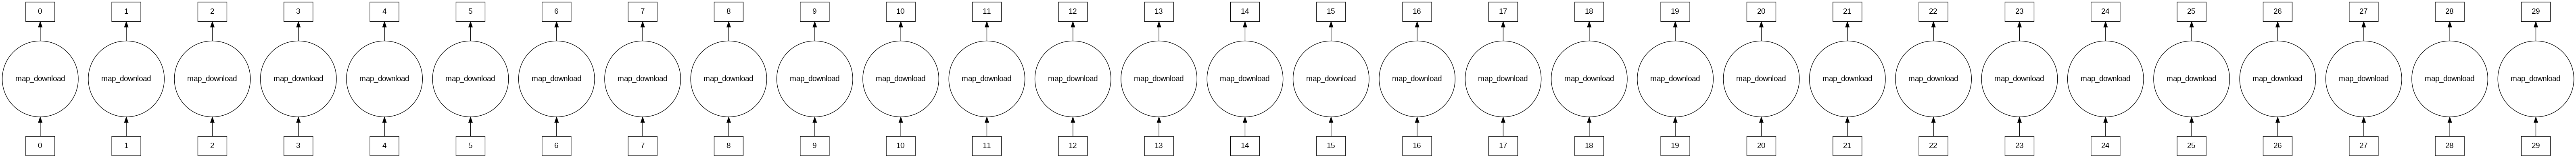

In [ ]:
task.visualize()

In [ ]:
task.compute()

KeyboardInterrupt: 

In [ ]:
p_clean.query("download_method == 'gallery'").sample(n = 10)

,id,author,selftext,title,url,thumbnail,created_utc,is_self,media,over_18,domain,selftext_urls,before,after,download_method,clean_url
79186,9s03qx,[deleted],[deleted],"F/20/5'11"" [~195lbs &gt; 180lbs = 15lbs] (1.5m...",https://imgur.com/a/IPUNzJM,default,1540695148,False,{'oembed': {'description': 'Post with 28 votes...,False,imgur.com,None,None,None,gallery,https://imgur.com/a/IPUNzJM
15774,2cfyo9,[deleted],NaN,"M/19/5'6"" [198 &gt; 160 = 38] (9 months) Start...",http://imgur.com/a/VUKcL,default,1407006325,False,"{'type': 'imgur.com', 'oembed': {'type': 'rich...",False,imgur.com,None,None,None,gallery,http://imgur.com/a/VUKcL
51449,6wugwy,Hannahwith2hs,NaN,"F/27/5'8"" [200&gt;140= 60lbs] (12 months) Lost...",https://imgur.com/gallery/rGkqx,https://b.thumbs.redditmedia.com/DPB_uoVObdrrN...,1504042612,False,None,False,imgur.com,None,None,None,gallery,https://imgur.com/gallery/rGkqx
38265,51h0ef,bigmo3091,NaN,"M/24/5'10"" [382lbs &gt; 262lbs = 120lbs] Weigh...",http://imgur.com/a/RiWZK,http://b.thumbs.redditmedia.com/yArgiv6Oq1DluX...,1473190917,False,"{'type': 'imgur.com', 'oembed': {'html': '&lt;...",False,imgur.com,None,None,None,gallery,http://imgur.com/a/RiWZK
70945,919vmi,Rystar246,NaN,"M/20/6'0"" [109lbs &gt; 116lbs = 7lbs] 18 days....",https://imgur.com/a/7TcRfcv,https://b.thumbs.redditmedia.com/PI9ItR4NsCHQo...,1532372408,False,{'oembed': {'description': 'Post with 0 views....,False,imgur.com,None,None,None,gallery,https://imgur.com/a/7TcRfcv
63038,8ceo78,ricmac68,NaN,"M/49/5'6"" [575?&gt;235=340 ish](Around 36 mont...",https://imgur.com/a/CAYIa,nsfw,1523793265,False,{'oembed': {'description': 'Post with 2 views....,True,imgur.com,None,None,None,gallery,https://imgur.com/a/CAYIa
20763,2werx2,[deleted],NaN,M/16/6'1 [350&gt;250=100lbs] (13 months) Face ...,http://imgur.com/a/mrbjI,default,1424332143,False,{'oembed': {'thumbnail_url': 'http://i.imgur.c...,False,imgur.com,None,None,None,gallery,http://imgur.com/a/mrbjI
33170,4de5rw,brendanmhm,NaN,M/17/5'11'' [260lbs&gt;190] (1.5 years) Drab t...,http://imgur.com/a/Gr6q4,http://b.thumbs.redditmedia.com/Idw9_cUhV7LJiz...,1459818539,False,"{'type': 'imgur.com', 'oembed': {'thumbnail_ur...",False,imgur.com,None,None,None,gallery,http://imgur.com/a/Gr6q4
5445,1ggkkg,stownd,NaN,"M/29/5'11"" [265lbs &gt; 224lbs =41lbs lost] 9 ...",http://imgur.com/a/inanV,http://d.thumbs.redditmedia.com/9ZmAYY-osc6X3z...,1371399533,False,None,False,imgur.com,None,None,None,gallery,http://imgur.com/a/inanV
20880,2ww0ev,Jonnnnnnnnn,NaN,M/33/6'4 [264 &gt; 168 &gt; 189lbs] (10+ years...,http://imgur.com/a/c0L4w,http://b.thumbs.redditmedia.com/B-b8Eve36LCeNB...,1424712417,False,"{'type': 'imgur.com', 'oembed': {'title': ""M/3...",False,imgur.com,None,None,None,gallery,http://imgur.com/a/c0L4w


In [ ]:
!gallery-dl -q -d data/tidy_img/progresspics/gallery https://imgur.com/a/RiWZK

Now, clean the `before` and `after` column

1. If both before and after are galleries delete the row
  * It's too unpredictable what this means (which is the before and after photo?)
2. With the remaining, if one is a gallery

In [ ]:

p[(p.before.apply(detect_gallery) != False) & (p.after.apply(detect_gallery) != False)].shape


(200052, 15)

In [ ]:
p.sample(n = 30)

,id,author,selftext,title,url,thumbnail,created_utc,is_self,media,over_18,domain,selftext_urls,before,after,download_method
16033,2d7gcu,Rach827,NaN,[Image] I lost 110 lbs and learned an importan...,http://imgur.com/iumC3L5,http://a.thumbs.redditmedia.com/Ix_nxATSLvEAem...,1407731912,False,None,False,imgur.com,None,None,None,url
82277,a3pd8e,[deleted],[deleted],"F/28/5'10"" [280&gt;220 = 60lbs] (11 months) Cu...",https://imgur.com/a/fnA0Hke,default,1544113073,False,{'oembed': {'description': 'Post with 0 views....,False,imgur.com,None,None,None,gallery
63828,8f74lf,tla15,NaN,M/20/5’9” [151 &gt; 163 = +12] (6 months) From...,https://i.redd.it/zwsgftiy6cu01.jpg,https://b.thumbs.redditmedia.com/DUBvt6MpXBn8H...,1524784942,False,None,False,i.redd.it,None,None,None,url
120088,elvd7q,thisandthatofyou,NaN,F/36/6’ [245lbs &gt; 205lbs = 40lbs] March 201...,https://i.redd.it/t4xay6r85l941.jpg,https://b.thumbs.redditmedia.com/KDT6PqNiPk27H...,1578502635,False,None,False,i.redd.it,None,None,None,url
164966,lsrk06,[deleted],[deleted],F/25/5’7 (215&gt;193= 22lbs) I’ve lost 6in off...,https://i.redd.it/vs0zssgdlrj61.jpg,default,1614320241,False,None,True,i.redd.it,None,None,None,url
150040,j1diz7,xcdp10,NaN,"F/28/5'11"" [262 &gt; 160 = 102] 2.5yrs. I'm ba...",http://imgur.com/a/4wTRq1F,nsfw,1601305053,False,{'oembed': {'description': 'Post with 99 views...,True,imgur.com,None,None,None,gallery
207817,vrrtai,[deleted],[deleted],M/26/5’11” (395-191) done in 5 years💪🏻💪🏻💪🏻💪🏻,https://i.redd.it/kr4w0st6oq991.jpg,default,1657004189,False,None,False,i.redd.it,None,None,None,url
146569,ihmbyn,[deleted],[deleted],F/21/5’5” [150lbs &gt; 141 lbs = 9 lbs] 6 mont...,https://i.redd.it/snbm4zqg5kj51.jpg,default,1598539611,False,None,True,i.redd.it,None,None,None,url
148588,isn8h2,[deleted],[deleted],"4 months of Fitness, Everyday.",https://i.redd.it/z5vh6xitu4n51.jpg,default,1600097824,False,None,False,i.redd.it,None,None,None,url
75575,9fm6ep,Trapsntats,NaN,F/32/5’6” [198lb &gt; 172lb = 26lb] 6 months a...,https://i.imgur.com/JebhNFu.jpg,https://b.thumbs.redditmedia.com/A7Saal99RrMKk...,1536875066,False,None,False,i.imgur.com,None,None,None,url
